# A1 - DNN using pytorch

This notebook uses the classic [MNIST handwritten digit](https://git-disl.github.io/GTDLBench/datasets/mnist_datasets/) dataset, which contains digit 0-9 images of size 28*28. Our goal is to build a dense neural network to predict the class of digit.

For standarization purposes, you are required to use pytorch.

In [33]:
###checking if we are getting GPU in colab
###if not, Runtime → Change runtime type and Set Hardware accelerator to GPU
!nvidia-smi

Wed Jan 21 21:45:11 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P0             27W /   70W |     162MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## The MNIST dataset - Preprocessing


### Get the data
MNIST dataset is provided by torch directly. The following codes show how to load it.



In [35]:
help(datasets.MNIST)

Help on class MNIST in module torchvision.datasets.mnist:

class MNIST(torchvision.datasets.vision.VisionDataset)
 |  MNIST(root: Union[str, pathlib.Path], train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False) -> None
 |
 |  `MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.
 |
 |  Args:
 |      root (str or ``pathlib.Path``): Root directory of dataset where ``MNIST/raw/train-images-idx3-ubyte``
 |          and  ``MNIST/raw/t10k-images-idx3-ubyte`` exist.
 |      train (bool, optional): If True, creates dataset from ``train-images-idx3-ubyte``,
 |          otherwise from ``t10k-images-idx3-ubyte``.
 |      transform (callable, optional): A function/transform that  takes in a PIL image
 |          and returns a transformed version. E.g, ``transforms.RandomCrop``
 |      target_transform (callable, optional): A function/transform that takes in the
 |          target and transforms it.
 |      download (bool, opti

In [36]:
# the data, shuffled and split between train and test sets
# (downloads automatically if not present)
train_ds = datasets.MNIST(root='./data', train=True, download=True)
test_ds  = datasets.MNIST(root='./data', train=False, download=True)

X_train_pre = train_ds.data.numpy()     # (N, 28, 28), uint8
y_train_pre = train_ds.targets.numpy()  # (N,), int64
X_test_pre  = test_ds.data.numpy()
y_test_pre  = test_ds.targets.numpy()

### Reshape and normalize the features

In [37]:
input_dim = 784 # 28*28
X_train = X_train_pre.reshape(X_train_pre.shape[0], input_dim)
X_test = X_test_pre.reshape(X_test_pre.shape[0], input_dim)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.

print('training data shape:', X_train.shape)
print('{} train samples, {} test samples'.format(X_train.shape[0], X_test.shape[0]))

training data shape: (60000, 784)
60000 train samples, 10000 test samples


### convert class vectors to binary class matrices
convert class label to one-hot coding

In [38]:
y_train_pre[:5]

array([5, 0, 4, 1, 9])

In [39]:
num_classes = 10 # 0-9
# keep one-hot labels (to match the original notebook flow)
y_train = np.eye(num_classes, dtype=np.float32)[y_train_pre]
y_test = np.eye(num_classes, dtype=np.float32)[y_test_pre]

# the first 5 samples are 5,0,4,1,9
y_train[:5,]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [40]:
validation_split = 0.166667
index = np.random.permutation(X_train.shape[0])

train_idx = int(X_train.shape[0]*validation_split)

X_val, X_train = X_train[index[:train_idx]], X_train[index[train_idx:]]
y_val, y_train = y_train[index[:train_idx]], y_train[index[train_idx:]]

print('training data shape:', X_train.shape)
print('{} train samples, {} validation samples, {} test samples'\
      .format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

training data shape: (50000, 784)
50000 train samples, 10000 validation samples, 10000 test samples


## The models

### Build the model **1**

model 1: Build a 784-input 10-output perceptron, with no hidden layer for multi-class classification. This model is also known as the [multinomial logistic regression model](https://en.wikipedia.org/wiki/Multinomial_logistic_regression).

In [41]:
### Helper functions

class History:
    def __init__(self):
        self.history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}
        self.epoch = []


def model_summary(model: nn.Module, input_dim: int = 784):
    """Simple summary: architecture + parameter counts."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(model)
    print(f"\nTotal params: {total:,}")
    print(f"Trainable params: {trainable:,}")



def make_loaders(X_train, y_train_idx, X_val, y_val_idx, batch_size=128):
    Xtr = torch.from_numpy(X_train).float()
    ytr = torch.from_numpy(y_train_idx).long()
    Xva = torch.from_numpy(X_val).float()
    yva = torch.from_numpy(y_val_idx).long()

    train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(Xva, yva), batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs,
    metric_fn,
    early_stop_patience = None,
):
    history = History()
    best_val = float('inf')
    best_state = None
    patience_left = early_stop_patience

    for ep in range(epochs):
        #train
        model.train()
        train_loss_sum, train_correct, train_n = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            bs = xb.size(0)
            train_loss_sum += loss.item() * bs
            train_correct += metric_fn(logits, yb)
            train_n += bs

        train_loss = train_loss_sum / train_n
        train_acc = train_correct / train_n

        # --- val ---
        model.eval()
        val_loss_sum, val_correct, val_n = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)

                bs = xb.size(0)
                val_loss_sum += loss.item() * bs
                val_correct += metric_fn(logits, yb)
                val_n += bs

        val_loss = val_loss_sum / val_n
        val_acc = val_correct / val_n

        history.epoch.append(ep)
        history.history['loss'].append(train_loss)
        history.history['val_loss'].append(val_loss)
        history.history['accuracy'].append(train_acc)
        history.history['val_accuracy'].append(val_acc)

        print(f"Epoch {ep+1:02d}/{epochs} - loss: {train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

        # --- early stopping (optional) ---
        if early_stop_patience is not None:
            if val_loss < best_val - 1e-8:
                best_val = val_loss
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                patience_left = early_stop_patience
            else:
                patience_left -= 1
                if patience_left < 0:
                    print('Early stopping triggered.')
                    break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history


def evaluate_model(model, X, y_idx, batch_size=256):
    model.eval()
    Xte = torch.from_numpy(X).float()
    yte = torch.from_numpy(y_idx).long()
    loader = DataLoader(TensorDataset(Xte, yte), batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    loss_sum, correct, n = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            bs = xb.size(0)
            loss_sum += loss.item() * bs
            correct += (logits.argmax(dim=1) == yb).sum().item()
            n += bs
    return loss_sum / n, correct / n


def predict_proba(model, X, batch_size=256):
    model.eval()
    X_ = torch.from_numpy(X).float()
    loader = DataLoader(TensorDataset(X_), batch_size=batch_size, shuffle=False)
    probs = []
    with torch.no_grad():
        for (xb,) in loader:
            xb = xb.to(device)
            logits = model(xb)
            probs.append(F.softmax(logits, dim=1).cpu().numpy())
    return np.concatenate(probs, axis=0)


In [42]:
# Model: Multi-output Perceptron (multinomial logistic regression)
class Perceptron(nn.Module):
    ###fill in the blanks:
    def __init__(self, input_dim=784, num_classes=10):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        logits = self.fc(x)
        return logits

    def summary(self, model):
        model_parameters = filter(lambda p: p.requires_grad, model.parameters())

model = Perceptron().to(device)

# CrossEntropyLoss expects class indices, not one-hot vectors
def to_class_index(y):
    y = np.asarray(y)
    if y.ndim == 2:              # one-hot or probability-like
        return y.argmax(axis=1).astype(np.int64)
    return y.astype(np.int64)    # already class indices

y_train_idx = to_class_index(y_train)
y_val_idx   = to_class_index(y_val)
y_test_idx  = to_class_index(y_test)
# Fill in the following
# y_train_idx = y_train.argmax(axis=1)
# y_val_idx = y_val.argmax(axis=1)
# y_test_idx = y_test.argmax(axis=1)


### make loaders with batchsize = 128
train_loader, val_loader = make_loaders(X_train, y_train_idx, X_val, y_val_idx, batch_size= 128)


###What criterion should we use?
criterion = nn.CrossEntropyLoss()

###let us use RMSprop with lr = 0.001
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)


# accuracy metric: number of correct predictions
metric_fn = lambda logits, yb: (logits.argmax(dim=1) == yb).sum().item()

###Inspect the model

In [43]:
model_summary(model)

Perceptron(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

Total params: 7,850
Trainable params: 7,850


###Train the model

In [44]:
###Let us use EPOCHS = 20

EPOCHS = 20

history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=EPOCHS,
    metric_fn=metric_fn,
)

Epoch 01/20 - loss: 0.5241 - acc: 0.8707 - val_loss: 0.3668 - val_acc: 0.9027
Epoch 02/20 - loss: 0.3407 - acc: 0.9068 - val_loss: 0.3192 - val_acc: 0.9112
Epoch 03/20 - loss: 0.3089 - acc: 0.9143 - val_loss: 0.3006 - val_acc: 0.9159
Epoch 04/20 - loss: 0.2940 - acc: 0.9182 - val_loss: 0.2877 - val_acc: 0.9189
Epoch 05/20 - loss: 0.2842 - acc: 0.9211 - val_loss: 0.2811 - val_acc: 0.9194
Epoch 06/20 - loss: 0.2775 - acc: 0.9229 - val_loss: 0.2791 - val_acc: 0.9202
Epoch 07/20 - loss: 0.2727 - acc: 0.9241 - val_loss: 0.2743 - val_acc: 0.9221
Epoch 08/20 - loss: 0.2688 - acc: 0.9251 - val_loss: 0.2724 - val_acc: 0.9228
Epoch 09/20 - loss: 0.2656 - acc: 0.9265 - val_loss: 0.2713 - val_acc: 0.9220
Epoch 10/20 - loss: 0.2630 - acc: 0.9276 - val_loss: 0.2684 - val_acc: 0.9238
Epoch 11/20 - loss: 0.2602 - acc: 0.9279 - val_loss: 0.2674 - val_acc: 0.9245
Epoch 12/20 - loss: 0.2582 - acc: 0.9299 - val_loss: 0.2686 - val_acc: 0.9235
Epoch 13/20 - loss: 0.2566 - acc: 0.9292 - val_loss: 0.2666 - va

Plot historical training and validation losses

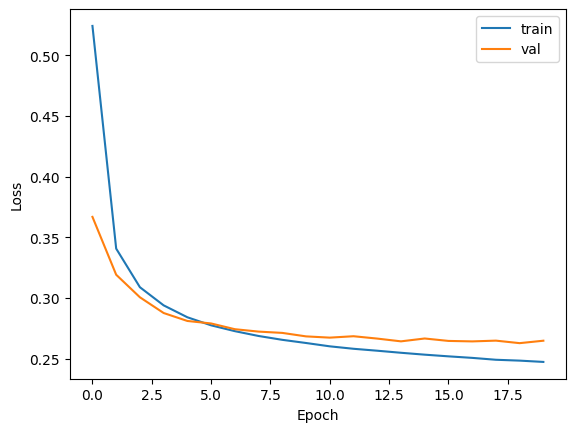

In [45]:
def plot_history_loss(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label="train")
    plt.plot(hist['epoch'], hist['val_loss'], label="val")
    plt.legend()
    plt.show()

plot_history_loss(history)


Plot historical training and validation accuracy

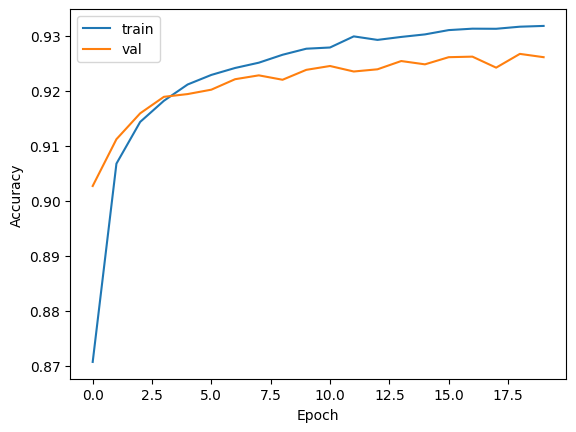

In [46]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'], label="train")
    plt.plot(hist['epoch'], hist['val_accuracy'], label="val")
    plt.legend()
    plt.show()

plot_history(history)


### Evaluate the model

In [47]:
_, acc = evaluate_model(model, X_test, y_test_idx)
print("Testing set accuracy: {:.2f}%".format(acc*100))


Testing set accuracy: 92.52%


### Build the model **2**: Two-layer fully-connected NN

In [48]:
# Please fill in the blanks
# Two-layer fully-connected NN
class TwoLayerNN(nn.Module):
  def __init__(self, input_dim=784, hidden_dim=256, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

  def forward(self, x):
        x = self.fc1(x)   # (batch_size, hidden_dim)
        x = self.act(x)   # nonlinearity
        logits = self.fc2(x)  # (batch_size, num_classes)
        return logits

  def summary(self, model):
        model_parameters = filter(lambda p: p.requires_grad, model.parameters())

model = TwoLayerNN(input_dim=input_dim, hidden_dim=256, num_classes=num_classes).to(device)


###same as model 1
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
metric_fn = lambda logits, yb: (logits.argmax(dim=1) == yb).sum().item()

In [49]:
model_summary(model)

TwoLayerNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (act): ReLU()
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Total params: 203,530
Trainable params: 203,530


### Train the model

In [50]:
EPOCHS = 20

history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=EPOCHS,
    metric_fn=metric_fn,
)


Epoch 01/20 - loss: 0.3083 - acc: 0.9102 - val_loss: 0.1965 - val_acc: 0.9410
Epoch 02/20 - loss: 0.1521 - acc: 0.9560 - val_loss: 0.1478 - val_acc: 0.9560
Epoch 03/20 - loss: 0.1048 - acc: 0.9694 - val_loss: 0.0966 - val_acc: 0.9713
Epoch 04/20 - loss: 0.0786 - acc: 0.9771 - val_loss: 0.0839 - val_acc: 0.9752
Epoch 05/20 - loss: 0.0615 - acc: 0.9821 - val_loss: 0.0810 - val_acc: 0.9745
Epoch 06/20 - loss: 0.0477 - acc: 0.9861 - val_loss: 0.0755 - val_acc: 0.9764
Epoch 07/20 - loss: 0.0375 - acc: 0.9889 - val_loss: 0.0800 - val_acc: 0.9749
Epoch 08/20 - loss: 0.0303 - acc: 0.9911 - val_loss: 0.0783 - val_acc: 0.9764
Epoch 09/20 - loss: 0.0236 - acc: 0.9934 - val_loss: 0.0671 - val_acc: 0.9798
Epoch 10/20 - loss: 0.0196 - acc: 0.9951 - val_loss: 0.0762 - val_acc: 0.9780
Epoch 11/20 - loss: 0.0146 - acc: 0.9965 - val_loss: 0.0841 - val_acc: 0.9747
Epoch 12/20 - loss: 0.0124 - acc: 0.9972 - val_loss: 0.0684 - val_acc: 0.9810
Epoch 13/20 - loss: 0.0096 - acc: 0.9978 - val_loss: 0.0753 - va

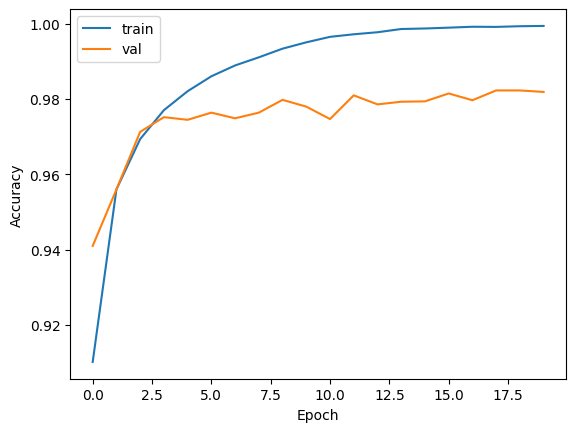

In [51]:
plot_history(history)

###Evaluate the model

In [52]:
_, acc = evaluate_model(model, X_test, y_test_idx)
print("Testing set accuracy: {:.2f}%".format(acc*100))


Testing set accuracy: 97.97%


### Make predictions for testing data

In [53]:
###Make precitions for X_test
y_pred = predict_proba(model, X_test).argmax(axis=1)
y_pred[:5]

array([7, 2, 1, 0, 4])

### Visualize the predictions.
#### Does your algorithm work as expected?
it does

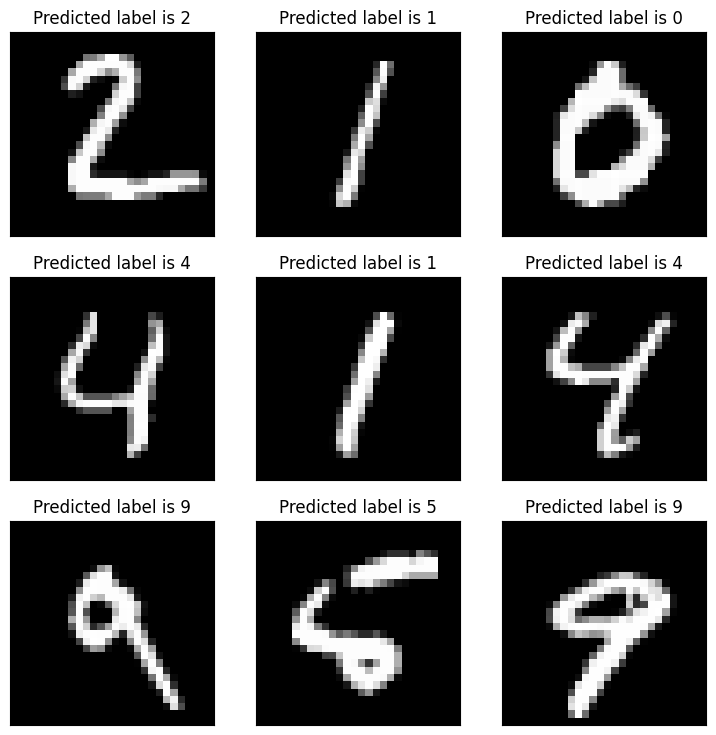

In [64]:
fig = plt.figure(figsize=(9, 9))
col = 3
row = 3
for i in range(1, col*row +1):
    pred = y_pred[i]
    img = X_test_pre[i,:]
    fig.add_subplot(row, col, i)
    plt.title('Predicted label is {}'.format(pred))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')
plt.show()

### Build the model **3**: Model 2 with early stopping

In [65]:
# Build a new model (same architecture as above)
model = TwoLayerNN(input_dim=input_dim, hidden_dim=256, num_classes=num_classes).to(device)

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
metric_fn = lambda logits, yb: (logits.argmax(dim=1) == yb).sum().item()


### Train the model with early stopping

Early stopping can be implemented by creating a custom class to monitor the validation loss or another metric and halt the training process if no improvement is observed for a specified number of epochs (patience). Libraries like PyTorch Lightning offer a built-in EarlyStopping callback that automates this process. In our code, we have already set up a patience parameter to control early stopping.

Patience: Number of epochs with no improvement after which training will be stopped. Defaults to 0.

In [66]:
EPOCHS = 20

# Early stopping: stop if val_loss doesn't improve for 2 epochs
# Fill in the following blanks

history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=EPOCHS,
    metric_fn=metric_fn,
    early_stop_patience = 2,
)

Epoch 01/20 - loss: 0.3052 - acc: 0.9127 - val_loss: 0.2091 - val_acc: 0.9357
Epoch 02/20 - loss: 0.1494 - acc: 0.9575 - val_loss: 0.1313 - val_acc: 0.9604
Epoch 03/20 - loss: 0.1044 - acc: 0.9698 - val_loss: 0.0988 - val_acc: 0.9692
Epoch 04/20 - loss: 0.0778 - acc: 0.9775 - val_loss: 0.0845 - val_acc: 0.9743
Epoch 05/20 - loss: 0.0601 - acc: 0.9831 - val_loss: 0.0797 - val_acc: 0.9768
Epoch 06/20 - loss: 0.0479 - acc: 0.9860 - val_loss: 0.0778 - val_acc: 0.9755
Epoch 07/20 - loss: 0.0374 - acc: 0.9891 - val_loss: 0.0741 - val_acc: 0.9767
Epoch 08/20 - loss: 0.0298 - acc: 0.9917 - val_loss: 0.0691 - val_acc: 0.9798
Epoch 09/20 - loss: 0.0233 - acc: 0.9941 - val_loss: 0.0722 - val_acc: 0.9786
Epoch 10/20 - loss: 0.0185 - acc: 0.9954 - val_loss: 0.0763 - val_acc: 0.9767
Epoch 11/20 - loss: 0.0149 - acc: 0.9961 - val_loss: 0.0735 - val_acc: 0.9800
Early stopping triggered.


### Evaluate the model

In [67]:
_, acc = evaluate_model(model, X_test, y_test_idx)
print("Testing set accuracy: {:.2f}%".format(acc*100))


Testing set accuracy: 97.89%


###What are your findings?

After we set early stop patience equals to 2, early stop was triggered after the 11-th epoch, which means that the val_loss is already close enough to the best value it can get and hasn't changed much for 2 epochs. And we still got a really high test set accuracy, which was 97.89%. This indicated that 12 epoch is well enough to train our model.

#Building Model 4: Binary Classification

How to write the code for a binary classification problem?

## Data Preprocessing

Consider predicting whether a handwritten digit is '8' or not.

In [58]:
y_train_8=y_train[:,8]
y_test_8=y_test[:,8]
y_val_8=y_val[:,8]

Generated labels are binary: 0 if the digit is not '8', 1 if the digit is '8'.

In [59]:
y_train_8

array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

Build a binary classification model. Difference

1. Output dimension for the final layer is 1
2. Activation function for the final layer is 'sigmoid'
3. Loss function is 'binary_crossentropy'



## Build the model

In [69]:
# Build a binary classification model
# Differences from multi-class:
# 1) Output dimension is 1 (logit)
# 2) Use BCEWithLogitsLoss (so NO sigmoid in the model)

class BinaryNN(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_dim, 1)  # ONE logit

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        logit = self.fc2(x)   # (batch_size, 1)
        return logit.squeeze(1)  # squeeze dimension to match with the input requirement of BCEWithLogitsLoss

    def summary(self, model):
        model_parameters = filter(lambda p: p.requires_grad, model.parameters())

model = BinaryNN().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()


In [71]:
model_summary(model)

BinaryNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (act): Sigmoid()
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

Total params: 201,217
Trainable params: 201,217


## Train the model

Train the model on the binary labels.

In [72]:
def make_binary_loaders(X_train, y_train_bin, X_val, y_val_bin, batch_size=128):
    Xtr = torch.from_numpy(X_train).float()
    ytr = torch.from_numpy(y_train_bin).float()
    Xva = torch.from_numpy(X_val).float()
    yva = torch.from_numpy(y_val_bin).float()

    train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(Xva, yva), batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


def train_model_binary(model, train_loader, val_loader, optimizer, criterion, epochs, early_stop_patience=None):
    history = History()
    best_val = float('inf')
    best_state = None
    patience_left = early_stop_patience

    for ep in range(epochs):
        model.train()
        train_loss_sum, train_correct, train_n = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            bs = xb.size(0)
            train_loss_sum += loss.item() * bs
            preds = (torch.sigmoid(logits) > 0.5).float()
            train_correct += (preds == yb).sum().item()
            train_n += bs

        train_loss = train_loss_sum / train_n
        train_acc = train_correct / train_n

        model.eval()
        val_loss_sum, val_correct, val_n = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)

                bs = xb.size(0)
                val_loss_sum += loss.item() * bs
                preds = (torch.sigmoid(logits) > 0.5).float()
                val_correct += (preds == yb).sum().item()
                val_n += bs

        val_loss = val_loss_sum / val_n
        val_acc = val_correct / val_n

        history.epoch.append(ep)
        history.history['loss'].append(train_loss)
        history.history['val_loss'].append(val_loss)
        history.history['accuracy'].append(train_acc)
        history.history['val_accuracy'].append(val_acc)

        print(f"Epoch {ep+1:02d}/{epochs} - loss: {train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

        if early_stop_patience is not None:
            if val_loss < best_val - 1e-8:
                best_val = val_loss
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                patience_left = early_stop_patience
            else:
                patience_left -= 1
                if patience_left < 0:
                    print('Early stopping triggered.')
                    break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history


def evaluate_model_binary(model, X, y_bin, batch_size=256):
    model.eval()
    Xte = torch.from_numpy(X).float()
    yte = torch.from_numpy(y_bin).float()
    loader = DataLoader(TensorDataset(Xte, yte), batch_size=batch_size, shuffle=False)

    criterion = nn.BCEWithLogitsLoss()
    loss_sum, correct, n = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            bs = xb.size(0)
            loss_sum += loss.item() * bs
            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds == yb).sum().item()
            n += bs

    return loss_sum / n, correct / n


EPOCHS = 10

train_loader_bin, val_loader_bin = make_binary_loaders(X_train, y_train_8, X_val, y_val_8, batch_size=128)

history = train_model_binary(
    model,
    train_loader_bin,
    val_loader_bin,
    optimizer,
    criterion,
    epochs=EPOCHS,
)


Epoch 01/10 - loss: 0.1386 - acc: 0.9520 - val_loss: 0.1254 - val_acc: 0.9568
Epoch 02/10 - loss: 0.0937 - acc: 0.9686 - val_loss: 0.0865 - val_acc: 0.9724
Epoch 03/10 - loss: 0.0661 - acc: 0.9782 - val_loss: 0.0749 - val_acc: 0.9751
Epoch 04/10 - loss: 0.0518 - acc: 0.9833 - val_loss: 0.0499 - val_acc: 0.9834
Epoch 05/10 - loss: 0.0428 - acc: 0.9859 - val_loss: 0.0435 - val_acc: 0.9856
Epoch 06/10 - loss: 0.0355 - acc: 0.9880 - val_loss: 0.0381 - val_acc: 0.9869
Epoch 07/10 - loss: 0.0301 - acc: 0.9901 - val_loss: 0.0330 - val_acc: 0.9893
Epoch 08/10 - loss: 0.0258 - acc: 0.9915 - val_loss: 0.0294 - val_acc: 0.9900
Epoch 09/10 - loss: 0.0223 - acc: 0.9927 - val_loss: 0.0271 - val_acc: 0.9911
Epoch 10/10 - loss: 0.0188 - acc: 0.9939 - val_loss: 0.0261 - val_acc: 0.9916


## Evaluate the model

The binary classification task is easier than the 10-class one. It is expected we see a better performance.

In [73]:
_, acc = evaluate_model_binary(model, X_test, y_test_8)
print("Testing set accuracy: {:.2f}%".format(acc*100))


Testing set accuracy: 99.21%


###Summarize your findings

We see a higher testing set accuracy 99.21% than other models and tasks, which is indeed as expected.